In [34]:
#loading require python packages
import os
import cv2
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential
import pickle
from keras.applications import ResNet50 #importing resnet50 class
from keras.applications import ResNet101#importing resnet101 class
from keras.applications import VGG16 #importing VGG16 class
from keras.applications import InceptionV3 #importing Inception GoogleNet class
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
import pandas as pd
from keras import Model, layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from keras.models import load_model

In [84]:
labels = ['Normal', 'Cancer']

In [85]:
X = []
Y = []
path = "HistopathologyDataset"
if os.path.exists('model/X.txt.npy'):
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else:
    for root, dirs, directory in os.walk(path):
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j]) #read image from dataset directory
                img = cv2.resize(img, (75, 75)) #resize image
                im2arr = np.array(img)
                im2arr = im2arr.reshape(75, 75, 3) #image as 3 colour format
                X.append(im2arr) #add images to array
                label = 0
                if name == "Cancer":
                    label = 1
                Y.append(label) #add class label to Y variable
                print(name+" "+str(label))
    X = np.asarray(X) #convert array images to numpy array
    Y = np.asarray(Y)
    np.save('model/X.txt',X)
    np.save('model/Y.txt',Y)
print("Total images found in dataset: "+str(X.shape[0]))

Total images found in dataset: 1513


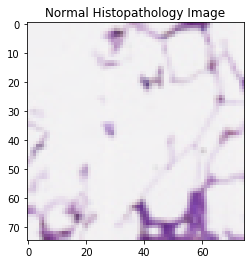

In [86]:
normal = None
cancer = None
for i in range(100,1000):
    if Y[i] == 0:
        normal = X[i]
        break
for i in range(100,1000):
    if Y[i] == 1:
        cancer = X[i]
        break    
plt.title("Normal Histopathology Image") #display one pprocesses image
plt.imshow(normal)
plt.show()         

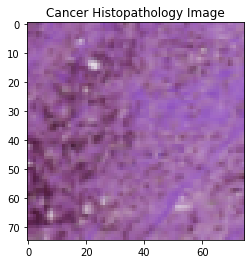

In [87]:
plt.title("Cancer Histopathology Image") #display one pprocesses image
plt.imshow(cancer)
plt.show()     

In [88]:
X = X.astype('float32')
X = X/255 #normalize image
indices = np.arange(X.shape[0])
np.random.shuffle(indices) #shuffle images data
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and tesrt
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Training Size (20%): "+str(X_test.shape[0]))

Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 1210
Training Size (20%): 303


In [89]:
precision = []
recall = []
fscore = []
accuracies = []

In [90]:
#function to calculate accuracy and other metrics by comparing original label and predicted label
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100  
    conf_matrix = confusion_matrix(testY, predict) 
    se = (conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])) * 100
    sp = (conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])) * 100
    print()
    print(algorithm+' Accuracy    : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FScore      : '+str(f))
    accuracies.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    plt.figure(figsize =(6, 6)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,2])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

In [91]:
#train Resnet50 algorithms
#defining RESNET50 object and then adding layers for imagenet with CNN and max pooling filter layers
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in resnet.layers:
    layer.trainable = False
resnet_classifier = Sequential()
resnet_classifier.add(resnet)
resnet_classifier.add(Convolution2D(32, 1, 1, input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
resnet_classifier.add(MaxPooling2D(pool_size = (1, 1)))
resnet_classifier.add(Convolution2D(32, 1, 1, activation = 'relu'))
resnet_classifier.add(MaxPooling2D(pool_size = (1, 1)))
resnet_classifier.add(Flatten())
resnet_classifier.add(Dense(output_dim = 256, activation = 'relu'))
resnet_classifier.add(Dense(output_dim = y_train.shape[1], activation = 'softmax'))
print(resnet_classifier.summary())
resnet_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/resnet50_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/resnet50_weights.hdf5', verbose = 1, save_best_only = True)
    hist = resnet_classifier.fit(X_train, y_train, batch_size=64, epochs=10, shuffle=True, validation_data=(X_test, y_test), callbacks=[model_check_point])
    f = open('model/resnet50_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    resnet_classifier = load_model("model/resnet50_weights.hdf5")
  

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), input_shape=(75, 75, 3..., activation="relu")`
  
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  del sys.path[0]
c:\users\admin\appdata\local\progra

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 3, 3, 2048)        23587712  
_________________________________________________________________
conv2d_314 (Conv2D)          (None, 3, 3, 32)          65568     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_315 (Conv2D)          (None, 3, 3, 32)          1056      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)             

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Resnet50 Accuracy    : 48.51485148514851
Resnet50 Precision   : 24.257425742574256
Resnet50 Recall      : 50.0
Resnet50 FScore      : 32.666666666666664


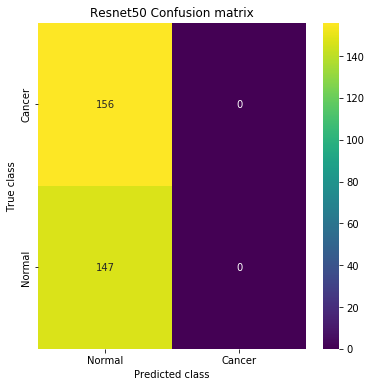

In [92]:
predict = resnet_classifier.predict(X_test) #perform prediction on test data
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test, axis=1)
calculateMetrics("Resnet50", predict, testY)  #call function to calculate metrics

In [93]:
#defining RESNET101 object and then adding layers for imagenet with CNN and max pooling filter layers
resnet = ResNet101(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in resnet.layers:
    layer.trainable = False
resnet101_classifier = Sequential()
resnet101_classifier.add(resnet)
resnet101_classifier.add(Convolution2D(32, 1, 1, input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
resnet101_classifier.add(MaxPooling2D(pool_size = (1, 1)))
resnet101_classifier.add(Convolution2D(32, 1, 1, activation = 'relu'))
resnet101_classifier.add(MaxPooling2D(pool_size = (1, 1)))
resnet101_classifier.add(Flatten())
resnet101_classifier.add(Dense(output_dim = 256, activation = 'relu'))
resnet101_classifier.add(Dense(output_dim = y_train.shape[1], activation = 'softmax'))
print(resnet101_classifier.summary())
resnet101_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/resnet101_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/resnet101_weights.hdf5', verbose = 1, save_best_only = True)
    hist = classifier.fit(X_train, y_train, batch_size=64, epochs=10, shuffle=True, validation_data=(X_test, y_test), callbacks=[model_check_point])
    f = open('model/resnet101_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    resnet101_classifier.load_weights("model/resnet101_weights.hdf5")

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), input_shape=(75, 75, 3..., activation="relu")`
  import sys
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
  if __name__ == '__main__':
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  if sys.path[0] == '':
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=2)`
  del sys.path[0]


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 3, 3, 2048)        42658176  
_________________________________________________________________
conv2d_316 (Conv2D)          (None, 3, 3, 32)          65568     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_317 (Conv2D)          (None, 3, 3, 32)          1056      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 256)             


Resnet101 Accuracy    : 48.51485148514851
Resnet101 Precision   : 35.0
Resnet101 Recall      : 47.17425431711146
Resnet101 FScore      : 34.28428428428428


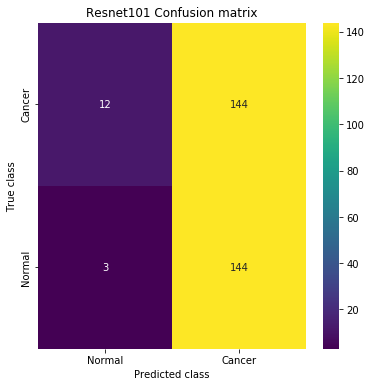

In [94]:
#prediction on test data using resnet101
predict = resnet101_classifier.predict(X_test)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test, axis=1)
calculateMetrics("Resnet101", predict, testY)  

In [95]:
#training with GoogleNet group algorithm called inceptionv3
inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in inception.layers:
    layer.trainable = False
inception_classifier = Sequential()
inception_classifier.add(inception)
inception_classifier.add(Convolution2D(32, 1, 1, input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
inception_classifier.add(MaxPooling2D(pool_size = (1, 1)))
inception_classifier.add(Convolution2D(32, 1, 1, activation = 'relu'))
inception_classifier.add(MaxPooling2D(pool_size = (1, 1)))
inception_classifier.add(Flatten())
inception_classifier.add(Dense(output_dim = 256, activation = 'relu'))
inception_classifier.add(Dense(output_dim = y_train.shape[1], activation = 'softmax'))
print(inception_classifier.summary())
inception_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/inception_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/inception_weights.hdf5', verbose = 1, save_best_only = True)
    hist = inception_classifier.fit(X_train, y_train, batch_size=64, epochs=10, shuffle=True, validation_data=(X_test, y_test), callbacks=[model_check_point])
    f = open('model/inception_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    inception_classifier.load_weights("model/inception_weights.hdf5")

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), input_shape=(75, 75, 3..., activation="relu")`
  import sys
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
  if __name__ == '__main__':
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  if sys.path[0] == '':
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=2)`
  del sys.path[0]


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
conv2d_412 (Conv2D)          (None, 1, 1, 32)          65568     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 1, 1, 32)          0         
_________________________________________________________________
conv2d_413 (Conv2D)          (None, 1, 1, 32)          1056      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)             


GoogleNet Accuracy    : 36.96369636963696
GoogleNet Precision   : 36.387950450450454
GoogleNet Recall      : 37.349555206698064
GoogleNet FScore      : 36.06111829239999


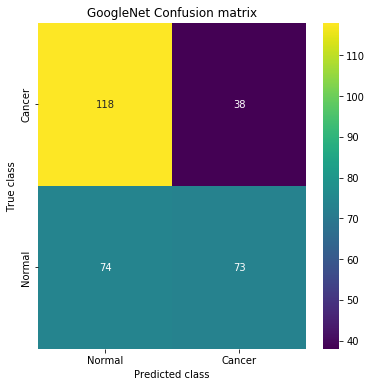

In [96]:
#prediction on test data using GoogleNet
predict = inception_classifier.predict(X_test)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test, axis=1)
calculateMetrics("GoogleNet", predict, testY) 

In [97]:
#defining vgg16 object and then adding layers for imagenet with CNN and max pooling filter layers
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in vgg.layers:
    layer.trainable = False
vgg_classifier = Sequential()
vgg_classifier.add(vgg)
vgg_classifier.add(Convolution2D(32, 1, 1, input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
vgg_classifier.add(MaxPooling2D(pool_size = (1, 1)))
vgg_classifier.add(Convolution2D(32, 1, 1, activation = 'relu'))
vgg_classifier.add(MaxPooling2D(pool_size = (1, 1)))
vgg_classifier.add(Flatten())
vgg_classifier.add(Dense(output_dim = 256, activation = 'relu'))
vgg_classifier.add(Dense(output_dim = y_train.shape[1], activation = 'softmax'))
print(vgg_classifier.summary())
vgg_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/vgg_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/vgg_weights.hdf5', verbose = 1, save_best_only = True)
    hist = vgg_classifier.fit(X_train, y_train, batch_size=64, epochs=10, shuffle=True, validation_data=(X_test, y_test), callbacks=[model_check_point])
    f = open('model/vgg_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    vgg_classifier.load_weights("model/vgg_weights.hdf5")

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), input_shape=(75, 75, 3..., activation="relu")`
  import sys
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
  if __name__ == '__main__':
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  if sys.path[0] == '':
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=2)`
  del sys.path[0]


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
conv2d_414 (Conv2D)          (None, 2, 2, 32)          16416     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_415 (Conv2D)          (None, 2, 2, 32)          1056      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)             


VGG16 Accuracy    : 94.38943894389439
VGG16 Precision   : 94.37908496732025
VGG16 Recall      : 94.41391941391942
VGG16 FScore      : 94.38723807655846


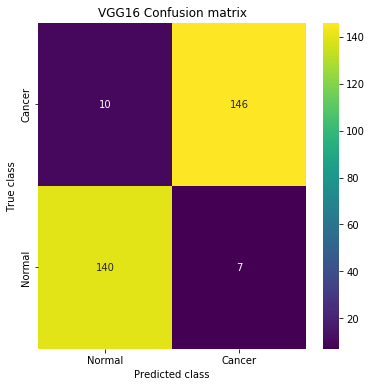

In [98]:
#prediction on test data using VGG16
predict = vgg_classifier.predict(X_test)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test, axis=1)
calculateMetrics("VGG16", predict, testY) 

In [ ]:
#training with Alexnet algortihm
#defining layers of alexnet model
import keras
alexnet_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(2,2), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(y_train.shape[1], activation='softmax')
])
#compiling alexnet model
alexnet_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
if os.path.exists("model/alexnet_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/alexnet_weights.hdf5', verbose = 1, save_best_only = True)
    hist = alexnet_model.fit(X_train, y_train, batch_size=64, epochs=10, shuffle=True, validation_data=(X_test, y_test), callbacks=[model_check_point])
    f = open('model/alexnet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    alexnet_model.load_weights("model/alexnet_weights.hdf5")
print(alexnet_model.summary())    


Alexnet Accuracy    : 89.76897689768977
Alexnet Precision   : 90.28009849617449
Alexnet Recall      : 89.94636316064887
Alexnet FScore      : 89.75782093360522


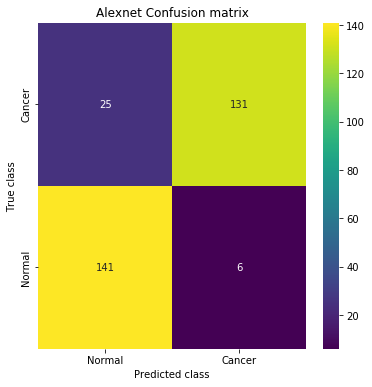

In [100]:
#prediction on test data using Alexnet
predict = alexnet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test, axis=1)
calculateMetrics("Alexnet", predict, testY)

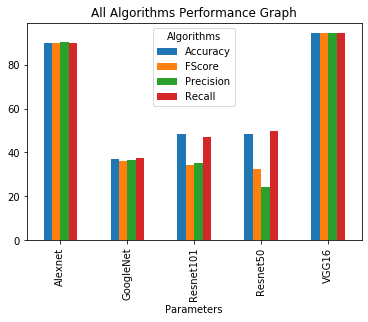

In [101]:
df = pd.DataFrame([['Resnet50','FScore',fscore[0]],['Resnet50','Recall',recall[0]],['Resnet50','Precision',precision[0]],['Resnet50','Accuracy',accuracies[0]],
                   ['Resnet101','FScore',fscore[1]],['Resnet101','Recall',recall[1]],['Resnet101','Precision',precision[1]],['Resnet101','Accuracy',accuracies[1]], 
                   ['GoogleNet','FScore',fscore[2]],['GoogleNet','Recall',recall[2]],['GoogleNet','Precision',precision[2]],['GoogleNet','Accuracy',accuracies[2]],
                   ['VGG16','FScore',fscore[3]],['VGG16','Recall',recall[3]],['VGG16','Precision',precision[3]],['VGG16','Accuracy',accuracies[3]], 
                   ['Alexnet','FScore',fscore[4]],['Alexnet','Recall',recall[4]],['Alexnet','Precision',precision[4]],['Alexnet','Accuracy',accuracies[4]],                 
    
],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar')
plt.title("All Algorithms Performance Graph")
plt.show()

In [102]:
columns = ["Algorithm Name", "FScore", "Recall", "Precison", "Accuracy"]
values = []
algorithm_names = ["Resnet50","Resnet101", "GoogleNet", "VGG16", "Alexnet"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i], fscore[i], recall[i], precision[i], accuracies[i]])
temp = pd.DataFrame(values,columns=columns)
display(temp)

,Algorithm Name,FScore,Recall,Precison,Accuracy
0,Resnet50,32.666667,50.000000,24.257426,48.514851
1,Resnet101,34.284284,47.174254,35.000000,48.514851
2,GoogleNet,36.061118,37.349555,36.387950,36.963696
3,VGG16,94.387238,94.413919,94.379085,94.389439
4,Alexnet,89.757821,89.946363,90.280098,89.768977
